# New York City 311 Data

## Overview

In the city of New York, citizens with non-emergency complaints (e.g. trash non-collection, rodent infestations) can call 311 to make a Service Request.  These are recorded and shared on New York's open data site at  https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9.

## High-Level Description

The data dates from 2010 to the current day, with data being updated on a daily basis.  At the time of this writing, there are over 20 million rows, each row representing a single service request, and over 40 columns which represent aspects of each service request, such as the street address being referenced, the type of complaint, the agency responsible, the date of the service request, etc.

## Bring in Data via pandas

I'm only going to bring in only the rows that have 'Pothole' in the `descriptor` field.  I'll set an upper limit of 5 million rows.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
potholes = pd.read_csv("https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?descriptor=Pothole&$limit=5000000")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's take a quick peek at what the data looks like.  Then we'll use pandas to work with it!

In [2]:
potholes.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location_city,location,location_address,location_zip,location_state
0,42035216,2019-03-23T15:37:36.000,2019-03-27T07:34:00.000,DOT,Department of Transportation,Street Condition,Pothole,NaN,11355.0,BOOTH MEMORIAL AVENUE,BOOTH MEMORIAL AVENUE,146 STREET,148 STREET,NaN,NaN,BLOCKFACE,Flushing,NaN,NaN,Closed,NaN,The Department of Transportation inspected thi...,2019-03-27T07:34:00.000,07 QUEENS,NaN,QUEENS,1033984.0,210706.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.744876,-73.820516,NaN,POINT (-73.820515773594 40.744876037242),NaN,NaN,NaN
1,42035218,2019-03-23T17:09:03.000,2019-03-27T10:13:00.000,DOT,Department of Transportation,Street Condition,Pothole,NaN,10314.0,NaN,NaN,NaN,NaN,MANOR ROAD,VICTORY BOULEVARD,INTERSECTION,STATEN ISLAND,NaN,NaN,Closed,NaN,The Department of Transportation inspected thi...,2019-03-27T10:13:00.000,01 STATEN ISLAND,NaN,STATEN ISLAND,950223.0,162661.0,UNKNOWN,Unspecified,STATEN ISLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.613078,-74.122557,NaN,POINT (-74.122556992381 40.613077936948),NaN,NaN,NaN
2,42036611,2019-03-23T19:04:12.000,NaN,DOT,Department of Transportation,Street Condition,Pothole,NaN,11377.0,NaN,NaN,NaN,NaN,BQE EB ENTRANCE QUEENS BLVD WB,BROOKLYN QUEENS EXPRESSWAY EN NB,INTERSECTION,Woodside,NaN,NaN,Pending,NaN,The Department of Transportation inspected thi...,2019-03-27T07:02:00.000,02 QUEENS,NaN,QUEENS,1012316.0,209017.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.740335,-73.898720,NaN,POINT (-73.898720018464 40.740335470005),NaN,NaN,NaN
3,42036612,2019-03-23T09:25:59.000,2019-03-27T13:20:00.000,DOT,Department of Transportation,Street Condition,Pothole,NaN,10314.0,NaN,NaN,NaN,NaN,DELMORE STREET,LIVERMORE AVENUE,INTERSECTION,STATEN ISLAND,NaN,NaN,Closed,NaN,The Department of Transportation inspected thi...,2019-03-27T13:20:00.000,01 STATEN ISLAND,NaN,STATEN ISLAND,945579.0,163320.0,UNKNOWN,Unspecified,STATEN ISLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.614868,-74.139287,NaN,POINT (-74.139287300499 40.614867702584),NaN,NaN,NaN
4,42036613,2019-03-23T13:40:15.000,2019-03-28T09:44:00.000,DOT,Department of Transportation,Street Condition,Pothole,NaN,10475.0,3285 ROMBOUTS AVENUE,ROMBOUTS AVENUE,CARVER LOOP,GIVAN AVENUE,NaN,NaN,ADDRESS,BRONX,NaN,NaN,Closed,NaN,The Department of Transportation inspected thi...,2019-03-28T09:44:00.000,10 BRONX,2.051410e+09,BRONX,1031923.0,259965.0,UNKNOWN,Unspecified,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.880089,-73.827604,NaN,POINT (-73.827603802742 40.880089328815),NaN,NaN,NaN


In [3]:
potholes.shape

(568911, 45)

OK, we have around 570 k rows, much less than our 5 million upper limit, but plenty to work with!  Let's do a bit of cleanup.  First, we'll do some date work.

In [0]:
for col in ['created_date', 'closed_date', 'due_date', 'resolution_action_updated_date']:
    potholes[col] = pd.to_datetime(potholes[col])
    potholes.loc[potholes[col] < '2007-01-01', col] = pd.NaT
    potholes.loc[potholes[col] > pd.Timestamp(dt.date.today())] = pd.NaT

potholes['resolved_date'] = np.where(potholes['closed_date'].notnull(), potholes['closed_date'], potholes['resolution_action_updated_date'])
potholes['days_to_close'] = (potholes['resolved_date'].dt.date - potholes['created_date'].dt.date).dt.days


# Get names of indexes for which days_to_close < 0
indexNames = potholes[potholes['days_to_close'] <0 ].index
# Drop them
potholes.drop(indexNames , inplace=True)

Let's change some of the geographic stuff.

In [0]:
new_lat_long = (potholes['location'].str.extract('.+(\-\d{2}\.*\d*) (\d{2}\.*\d*).+')).astype(float)
potholes.loc[:, 'longitude'] = new_lat_long[0]
potholes.loc[:, 'latitude'] = new_lat_long[1]

And let's remove "unspecified" boroughs and tickets that weren't closed.

In [0]:
indexNames = potholes[potholes['borough'] == 'Unspecified' ].index
potholes.drop(indexNames , inplace=True)

potholes.drop(potholes[potholes['status'] != "Closed"].index, axis=0, inplace=True)

In [7]:
potholes['resolution_description'].unique()

array(['The Department of Transportation inspected this complaint and repaired the problem.',
       'The Department of Transportation inspected this complaint and did not find the reported problem.',
       'The Department of Transportation inspected this complaint and found that the problem was fixed.',
       'The Department of Transportation determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.',
       'The Department of Transportation referred this complaint to the appropriate Maintenance Unit for repair.',
       'The Department of Transportation fixed all street defects at this location as part of a Capital Project.',
       nan,
       'The Department of Transportation inspected this complaint and found that the defect was not accessible. The repair will be rescheduled.',
       'The Department of Transportation assigned this complaint to a field crew for inspection and, if warranted, repair.',
       'The Dep

And create better, briefer resolution descriptions.

In [0]:
resolution_map = zip(potholes['resolution_description'].unique(), ["Repaired",
                                                                  "Did Not Find",
                                                                  "Repaired Already",
                                                                  "Duplicate",
                                                                  "Referred: Maintenance Unit",
                                                                  "Repaired: Capital Project",
                                                                  "No Description",
                                                                  "Rescheduled: Inaccessible",
                                                                  "Assigned: Field Crew",
                                                                  "Referred: Inspections Unit",
                                                                  "Future Maintenance Will Repair (Incomplete Decription)",
                                                                  "Status Not Available",
                                                                  "Future Maintenance Will Repair (Complete Decription)",
                                                                  "Not in DOT Jurisdiction (Not Specified)",
                                                                  "Completed or Corrected",
                                                                  "See Customer Notes",
                                                                  "Requires 6 Months for Response",
                                                                  "Not Repaired, was in Compliance",
                                                                  "Repair to be Scheduled",
                                                                  "Insufficient Information to Respond",
                                                                  "Not in DOT Jurisdiction (MTA)",
                                                                  "Not in DOT Jurisdiction (Parks and Rec)",
                                                                  "Referred: Barricaded",
                                                                  "Temporarily Repaired",
                                                                  "Not in DOT Jurisdiction (Other)",
                                                                  "Referred: Other DOT",
                                                                  "In Progress",
                                                                  "Referred: Dept. Environmental Protection",
                                                                  "Not in DOT Jurisdiction (State DOT)"
                                                                  ])

In [0]:
simple_map = zip(potholes['resolution_description'].unique(), ["Repaired",
                                                              "Not Repaired",
                                                              "Repaired",
                                                              "Duplicate",
                                                              "Not Repaired",
                                                              "Repaired",
                                                              "Unknown",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Unknown",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Repaired",
                                                              "Unknown",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired",
                                                              "Repaired",
                                                              "Not Repaired",
                                                              "Not Repaired"
                                                                  ])

In [0]:
potholes['shorter_resolution_desc'] = potholes['resolution_description'].map(dict(resolution_map))
potholes['shortest_resolution_desc'] = potholes['resolution_description'].map(dict(simple_map))

In [0]:
potholes.drop(potholes[potholes['shorter_resolution_desc'] == "Duplicate"].index, axis=0, inplace=True)

From previous work, I believe that the mean number of days for a pothole request to be resolved is different between boroughs.  We'd like to do some statistical checking to see if that's the case.  

We'll limit ourselves to just a subset of potholes.

We're first going to remove rows where the days to close is over 30, as these are outliers and may be linked to poor data collection procedures.  

We'll also remove rows where the days to close value is missing.

Finally, we'll just select rows that have a status of Closed.



In [0]:
potholes_1 = potholes[(potholes['days_to_close'].notnull()) & (potholes['days_to_close'] < 30) & (potholes['status'] == "Closed")]

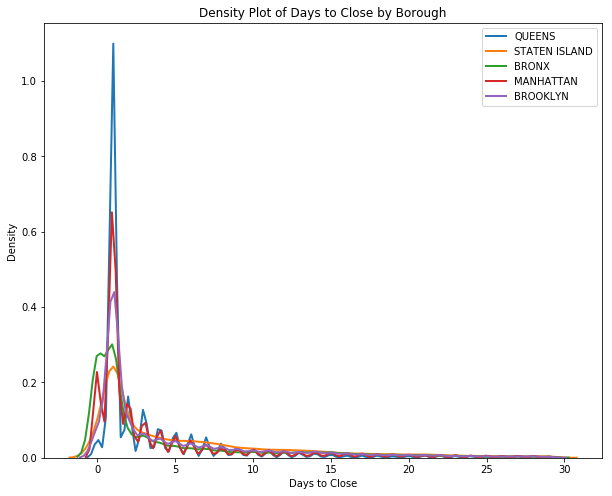

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.palettes import Category10_5
%matplotlib inline


# Create a figure
plt.figure(figsize=(10, 8))

# Iterate through each borough and make a density plot (kde)
for i, borough in enumerate(potholes_1['borough'].unique()):
    subset = potholes_1[potholes_1['borough'] == borough]
    sns.kdeplot(subset['days_to_close'], color = Category10_5[i], label = '%s' % borough, lw = 2 );

plt.xlabel('Days to Close')
plt.ylabel('Density')
plt.title('Density Plot of Days to Close by Borough')
plt.legend();

In [0]:
from scipy import stats

In [15]:
stats.f_oneway(potholes_1[['days_to_close']][potholes_1['borough']=="BRONX"],
               potholes_1[['days_to_close']][potholes_1['borough']=="BROOKLYN"],
               potholes_1[['days_to_close']][potholes_1['borough']=="MANHATTAN"],
               potholes_1[['days_to_close']][potholes_1['borough']=="QUEENS"],
               potholes_1[['days_to_close']][potholes_1['borough']=="STATEN ISLAND"]
              )

F_onewayResult(statistic=array([2413.61637834]), pvalue=array([0.]))

Sure looks like there's a very, very low p value.  Let's do some two-way T tests.  We'll do a couple here, and leave the rest for you to do!

In [16]:
stats.ttest_ind(potholes_1[['days_to_close']][potholes_1['borough']=="BRONX"], 
                potholes_1[['days_to_close']][potholes_1['borough']=="QUEENS"])

Ttest_indResult(statistic=array([35.62471398]), pvalue=array([3.42697212e-277]))

Wow, that's a tiny p value, which leads us to believe that we're seeing something real here in our sample data.  

In [17]:
stats.ttest_ind(potholes_1[['days_to_close']][potholes_1['borough']=="BROOKLYN"], 
                potholes_1[['days_to_close']][potholes_1['borough']=="MANHATTAN"])

Ttest_indResult(statistic=array([33.31122897]), pvalue=array([1.20464299e-242]))

Again, a super tiny p value.   This certainly appears to reflect a significant difference.   But while these differences have **statistical** significance, are they really that different?   Let's measure Cohen's effect size (d):

In [0]:
from numpy import var, mean
from math import sqrt
def cohens_d (first, second):
  s1, s2 = var(first, ddof=1), var(second, ddof=1)
  # calculate pooled standard deviation
  std = sqrt(((len(first) - 1) * s1 + (len(second) - 1) * s2) / (len(first) + len(second) - 2))
  return (mean(first)-  mean(second)) / std

In [19]:
cohens_d(potholes_1[['days_to_close']][potholes_1['borough']=="BRONX"], 
                potholes_1[['days_to_close']][potholes_1['borough']=="QUEENS"])

days_to_close    0.165342
dtype: float64

In [20]:
cohens_d(potholes_1[['days_to_close']][potholes_1['borough']=="BROOKLYN"], 
                potholes_1[['days_to_close']][potholes_1['borough']=="MANHATTAN"])

days_to_close    0.151906
dtype: float64

That's a pretty small effect size.  What it's telling us is that the variation within these two boroughs is much larger than the difference between them.